In [1]:
import pandas as pd
import numpy as np
import warnings 
import matplotlib.pyplot as plt
import seaborn as sns
import math
import shap
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from sklearn import kernel_ridge
from sklearn.kernel_ridge import KernelRidge
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import GridSearchCV

In [2]:
data = pd.read_csv('features.csv',  engine = 'python',  on_bad_lines = 'skip', index_col=[0])

In [3]:
warnings.filterwarnings('ignore')

In [4]:
data[data.isnull().any(axis=1)]

,NumberofFloors,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),...,Neighbor_NORTHEAST,Neighbor_NORTHWEST,Neighbor_North,Neighbor_Northwest,Neighbor_SOUTHEAST,Neighbor_SOUTHWEST,Built_1900-1945,Built_1946-1970,Built_1971-1990,Built_1991-2015


In [5]:
data = data.dropna(axis=0, how='any')

In [6]:
print(data.isnull().sum())

NumberofFloors                      0
ENERGYSTARScore                     0
SiteEUI(kBtu/sf)                    0
SiteEUIWN(kBtu/sf)                  0
SourceEUIWN(kBtu/sf)                0
SiteEnergyUse(kBtu)                 0
SiteEnergyUseWN(kBtu)               0
SteamUse(kBtu)                      0
Electricity(kBtu)                   0
NaturalGas(kBtu)                    0
GHGEmissionsIntensity               0
GHGEmissionsIntensity_log           0
SiteEUI(kBtu/sf)_log                0
Type_Distribution Center            0
Type_Hospital                       0
Type_Hotel                          0
Type_K-12 School                    0
Type_Laboratory                     0
Type_Large Office                   0
Type_Low-Rise Multifamily           0
Type_Medical Office                 0
Type_Mixed Use Property             0
Type_Other                          0
Type_Refrigerated Warehouse         0
Type_Residence Hall                 0
Type_Restaurant                     0
Type_Retail 

In [7]:
data.shape

(1534, 57)

In [8]:
data.head()

,NumberofFloors,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),...,Neighbor_NORTHEAST,Neighbor_NORTHWEST,Neighbor_North,Neighbor_Northwest,Neighbor_SOUTHEAST,Neighbor_SOUTHWEST,Built_1900-1945,Built_1946-1970,Built_1971-1990,Built_1991-2015
0,12,60.0,81.699997,84.300003,189.000000,7226362.5,7456910.0,2003882.00,3946027.0,1276453.0,...,0,0,0,0,0,0,1,0,0,0
1,11,61.0,94.800003,97.900002,179.399994,8387933.0,8664479.0,0.00,3242851.0,5145082.0,...,0,0,0,0,0,0,0,0,0,1
2,41,43.0,96.000000,97.699997,244.100006,72587024.0,73937112.0,21566554.00,49526664.0,1493800.0,...,0,0,0,0,0,0,0,1,0,0
3,10,56.0,110.800003,113.300003,224.000000,6794584.0,6946800.5,2214446.25,2768924.0,1811213.0,...,0,0,0,0,0,0,1,0,0,0
4,18,75.0,114.800003,118.699997,215.600006,14172606.0,14656503.0,0.00,5368607.0,8803998.0,...,0,0,0,0,0,0,0,0,1,0


# 3 Prédiction emission

## 3.1  Séléction des features 

### 3.1.1  Multivariate traitement pour éliminer les variables fortement corrélées

In [9]:
data_cols_num = ['ENERGYSTARScore', 'NumberofFloors', 'SiteEUI(kBtu/sf)', 'SiteEUIWN(kBtu/sf)', 'SourceEUIWN(kBtu/sf)','SiteEnergyUse(kBtu)', 'SiteEnergyUseWN(kBtu)', 'SteamUse(kBtu)', 'Electricity(kBtu)', 'NaturalGas(kBtu)', 'GHGEmissionsIntensity', 'GHGEmissionsIntensity_log', 'SiteEUI(kBtu/sf)_log']

In [10]:
y_cols_num = ['GHGEmissionsIntensity', 'GHGEmissionsIntensity_log', 'SiteEUI(kBtu/sf)_log', 'SiteEUI(kBtu/sf)', 'SiteEUIWN(kBtu/sf)' ]

In [11]:
# potentielles variables numériques pour X
X_cols_num = [col for col in data_cols_num if col not in y_cols_num]
print(X_cols_num)

['ENERGYSTARScore', 'NumberofFloors', 'SourceEUIWN(kBtu/sf)', 'SiteEnergyUse(kBtu)', 'SiteEnergyUseWN(kBtu)', 'SteamUse(kBtu)', 'Electricity(kBtu)', 'NaturalGas(kBtu)']


<Axes: >

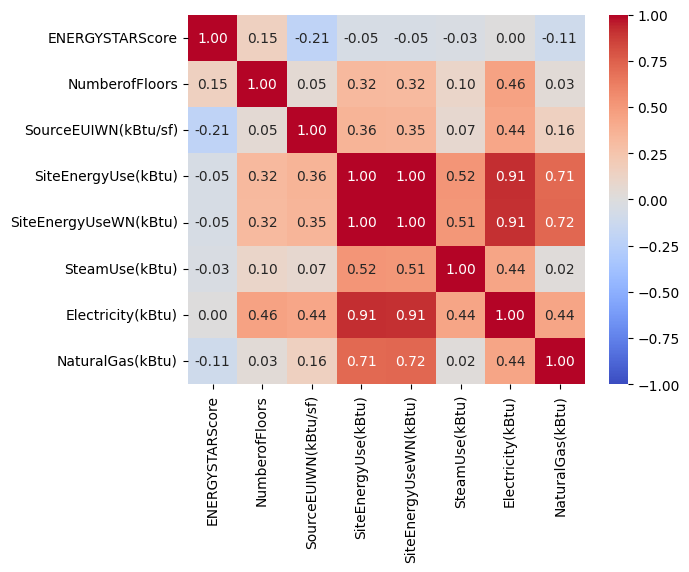

In [12]:
X_num = data[X_cols_num]
sns.heatmap(X_num.corr(), vmin=-1, vmax=1, annot=True, cmap="coolwarm", fmt="0.2f")

In [13]:
X_correlated = ['SourceEUIWN(kBtu/sf)', 'SiteEnergyUseWN(kBtu)', 'SiteEnergyUse(kBtu)']

In [14]:
X_num = X_num.drop(X_correlated, axis = 1)

<Axes: >

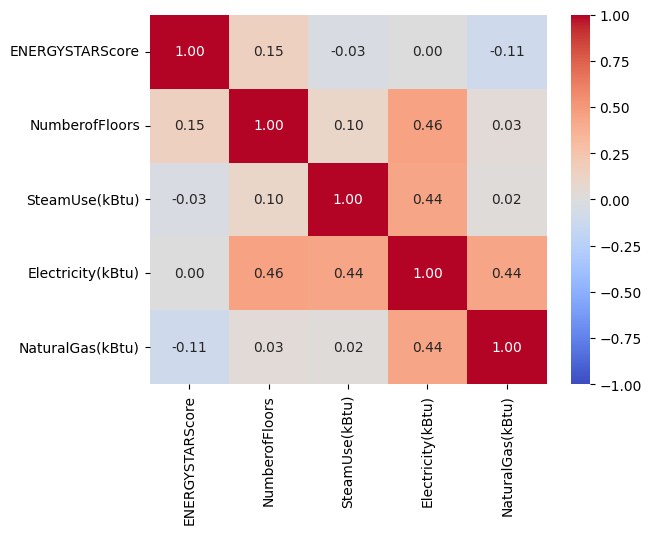

In [15]:
sns.heatmap(X_num.corr(), vmin=-1, vmax=1, annot=True, cmap="coolwarm", fmt="0.2f")

### 3.1.2  Sélection top 5 features 

In [16]:
y = data['SiteEUI(kBtu/sf)']

In [17]:
# Perform feature selection using a univariate statistical test
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif # use this for classification tasks
from sklearn.feature_selection import f_regression # use this for regression tasks

# Split into train (2/3) and test (1/3) sets
test_size = 0.33
seed = 7
X_train, X_test, y_train, y_test = train_test_split(X_num, y, test_size=test_size, random_state=seed)
print(X_train.shape)
print(X_test.shape)

kbest = SelectKBest(score_func=f_regression, k=5)
kbest.fit(X_train, y_train)

X_cols_selected = list(X_num.columns[kbest.get_support()])
X_cols_unselected = list(X_num.columns[~kbest.get_support()])
print("Feature selection", kbest.get_support())
print("Feature scores", kbest.scores_)
print("Selected features:", X_cols_selected)
print("Removed features:", X_cols_unselected)

(1027, 5)
(507, 5)
Feature selection [ True  True  True  True  True]
Feature scores [6.56511303e+01 3.32199042e-02 1.27351540e+01 1.32778686e+02
 6.39671269e+01]
Selected features: ['ENERGYSTARScore', 'NumberofFloors', 'SteamUse(kBtu)', 'Electricity(kBtu)', 'NaturalGas(kBtu)']
Removed features: []


In [18]:
X_num= data[X_cols_selected]
X_num.head()

,ENERGYSTARScore,NumberofFloors,SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu)
0,60.0,12,2003882.00,3946027.0,1276453.0
1,61.0,11,0.00,3242851.0,5145082.0
2,43.0,41,21566554.00,49526664.0,1493800.0
3,56.0,10,2214446.25,2768924.0,1811213.0
4,75.0,18,0.00,5368607.0,8803998.0


In [19]:
X_num.columns

Index(['ENERGYSTARScore', 'NumberofFloors', 'SteamUse(kBtu)',
       'Electricity(kBtu)', 'NaturalGas(kBtu)'],
      dtype='object')

## 3.2. préparation des données

In [20]:
X_cols_num = X_num.columns
len(X_cols_num)

5

In [21]:
X_cols_remove = y_cols_num + X_correlated + X_cols_unselected
print(X_cols_remove)

['GHGEmissionsIntensity', 'GHGEmissionsIntensity_log', 'SiteEUI(kBtu/sf)_log', 'SiteEUI(kBtu/sf)', 'SiteEUIWN(kBtu/sf)', 'SourceEUIWN(kBtu/sf)', 'SiteEnergyUseWN(kBtu)', 'SiteEnergyUse(kBtu)']


In [22]:
X_data = data.drop(X_cols_remove, axis = 1)
X = data.drop(X_cols_remove, axis = 1).values
y = data['SiteEUI(kBtu/sf)'].values
#y = data['GHGEmissionsIntensity_log'].values

In [23]:
# séparation de train et test 
from sklearn import model_selection
X_train, X_test, y_train, y_test = \
    model_selection.train_test_split(X, y, test_size=0.2, random_state=42)

In [24]:
# normalisation seulement des variables numériques
scaler = StandardScaler()

X_train_num = X_train[:, :len(X_cols_num)]
scaler.fit(X_train_num)

X_train_cat = X_train[:, len(X_cols_num):]
X_train_num_std = scaler.transform(X_train_num)
X_train_std = np.concatenate((X_train_num_std, X_train_cat), axis=1)

X_test_num = X_test[:, :len(X_cols_num)]
X_test_cat = X_test[:, len(X_cols_num):]
X_test_num_std = scaler.transform(X_test_num)   # utiliser scaler trainée par X_train pour scaler X_test_num. 
X_test_std = np.concatenate((X_test_num_std, X_test_cat), axis=1)


In [25]:
def performance(y_test, y_pred):
    mse = round(mean_squared_error(y_test, y_pred), 2)
    rmse = round(np.sqrt(mean_squared_error(y_test, y_pred)),2)
    r2 = round(r2_score(y_test, y_pred),2)
    print("MSE : ", mse, " RMSE: ", rmse, " R2 :",r2)
    return mse, rmse, r2

## 3.3 Choix de modèle et noyau

In [26]:
performance_list = []

### 3.3.1 Baseline avec dummy regression 

In [27]:
from sklearn.dummy import DummyRegressor
dummy_regressor = DummyRegressor(strategy='mean')

# Entraîner le dummy regressor sur les données d'entraînement
dummy_regressor.fit(X_train_std, y_train)

# Prédire les valeurs cibles pour les données de test
y_pred = dummy_regressor.predict(X_test_std)
y_pred_train = dummy_regressor.predict(X_train_std)

mse, rmse, r2 = performance(y_train, y_pred_train)
y_resultat = ['Dummy regression train', mse,rmse, r2 ]
performance_list.append(y_resultat)

mse, rmse, r2 = performance(y_test, y_pred)
y_resultat = ['Dummy regression test', mse, rmse, r2]
performance_list.append(y_resultat)

MSE :  6003.81  RMSE:  77.48  R2 : 0.0
MSE :  4199.78  RMSE:  64.81  R2 : -0.01


### 3.3.2   Modèle  avec  KernelRidgeRegression à  noyau 

In [28]:
# Noyau linéaire 
model = KernelRidge(alpha=1, kernel='linear')
model.fit(X_train_std, y_train)
y_pred = model.predict(X_test_std)
y_pred_train = model.predict(X_train_std)

mse, rmse, r2 = performance(y_train, y_pred_train)
y_resultat = ['KRR linear train', mse,rmse, r2 ]
performance_list.append(y_resultat)

mse, rmse, r2 = performance(y_test, y_pred)
y_resultat = ['KRR linear test', mse, rmse, r2]
performance_list.append(y_resultat)

MSE :  2858.43  RMSE:  53.46  R2 : 0.52
MSE :  3863.48  RMSE:  62.16  R2 : 0.07


In [29]:
shap.initjs()
# Calculer les contributions SHAP pour chaque caractéristique pour une prédiction donnée
explainer = shap.KernelExplainer(model.predict, X_train_std[:100])
shap_values = explainer.shap_values(X_test_std[3])

# Afficher les contributions SHAP pour chaque caractéristique
#shap.force_plot(explainer.expected_value, shap_values, X_test_std[0])

shap.force_plot(explainer.expected_value,
                explainer.shap_values(X_test_std[3]),
                feature_names=X_data.columns,
                out_names="SiteEUI(kBtu/sf)")


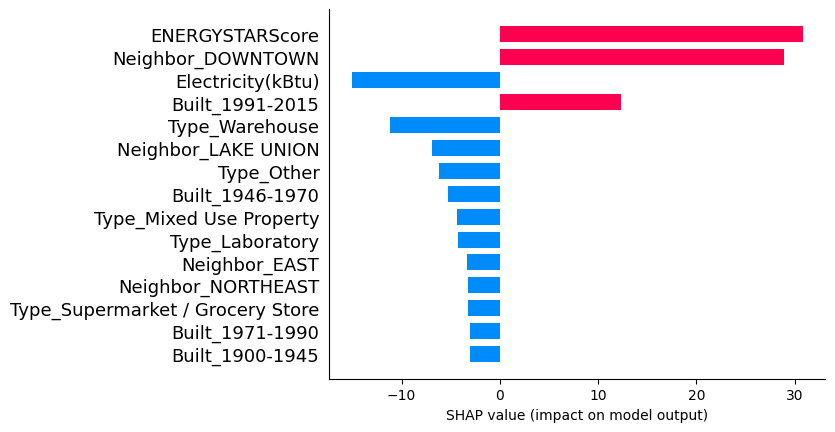

In [30]:
shap.bar_plot(explainer.shap_values(X_test_std[0]),
              feature_names=X_data.columns,
                 max_display=15)

  0%|          | 0/307 [00:00<?, ?it/s]

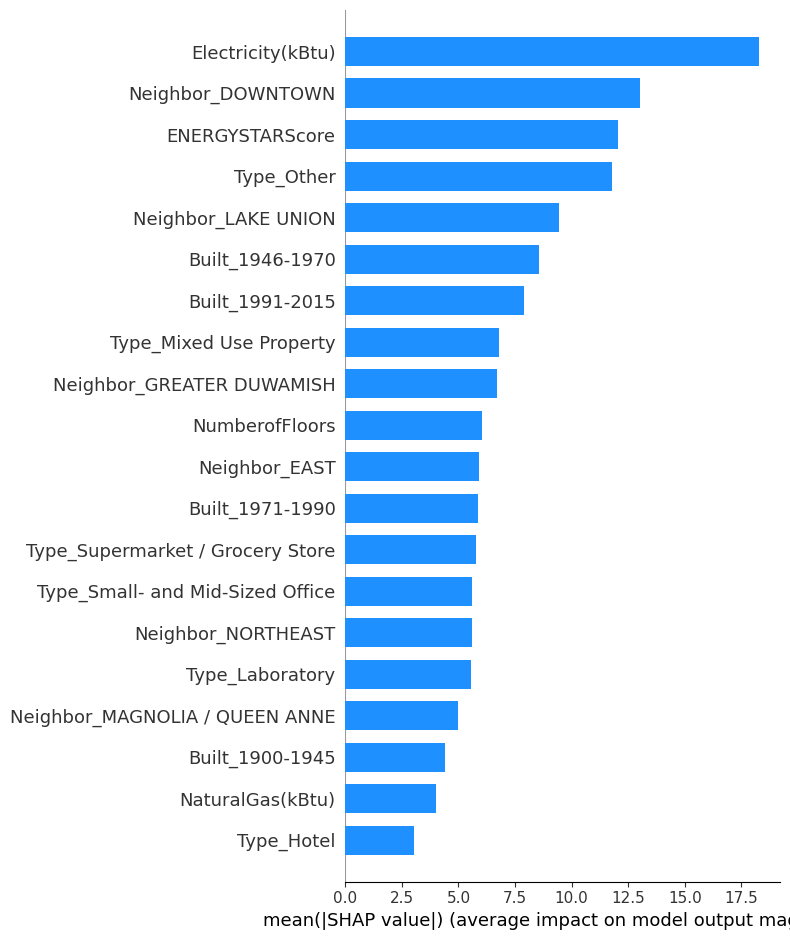

In [31]:
# l'importance relative de chaque variable explicative pour les prédictions du modèle.
shap.summary_plot(explainer.shap_values(X_test_std),
                  feature_names=X_data.columns,
                  plot_type="bar",
                  color="dodgerblue"
                  )

In [32]:
# avec Noyau non linéaire gaussien rbf 
model = KernelRidge(alpha=1, kernel='rbf', gamma=0.01)
model.fit(X_train_std, y_train)

y_pred = model.predict(X_test_std)
y_pred_train = model.predict(X_train_std)

mse, rmse, r2 = performance(y_train, y_pred_train)
y_resultat = ['KRR rbf train', mse,rmse, r2 ]
performance_list.append(y_resultat)

mse, rmse, r2 = performance(y_test, y_pred)
y_resultat = ['KRR rbf test', mse, rmse, r2]
performance_list.append(y_resultat)

MSE :  3004.49  RMSE:  54.81  R2 : 0.5
MSE :  2488.27  RMSE:  49.88  R2 : 0.4


In [33]:
# avec Noyau non linéaire polynomial
model = KernelRidge(alpha=1, kernel='polynomial', gamma=0.01)
model.fit(X_train_std, y_train)

y_pred = model.predict(X_test_std)
y_pred_train = model.predict(X_train_std)

mse, rmse, r2 = performance(y_train, y_pred_train)
y_resultat = ['KRR polynomial train', mse,rmse, r2 ]
performance_list.append(y_resultat)

mse, rmse, r2 = performance(y_test, y_pred)
y_resultat = ['KRR polynomial test', mse, rmse, r2]
performance_list.append(y_resultat)

MSE :  2740.21  RMSE:  52.35  R2 : 0.54
MSE :  24883.55  RMSE:  157.75  R2 : -4.99


Recheche des hyper paramètres par grilles de alpha, gamma et noyau

In [34]:
# Create a KRR model  ( Running time = 100s)
kr = KernelRidge()

# Définir la grille de paramètres à tester
param_grid = {
    'alpha': np.logspace(-2, 2, 4),
    'gamma': np.logspace(-4, 2, 5),
    'kernel': ['linear', 'polynomial', 'rbf']
#    'kernel': ['linear']
}

# Effectuer la recherche d'hyperparamètres par validation croisée et recherche en grille
grid_search = GridSearchCV(estimator=kr, param_grid=param_grid, cv=5,  n_jobs=-1, scoring='neg_mean_squared_error')
grid_search.fit(X_train_std, y_train)

# Afficher les meilleurs paramètres trouvés et leur performance
print("Meilleurs paramètres : ", grid_search.best_params_)
print("Meilleure performance : ", np.sqrt(-grid_search.best_score_))

# Utiliser les meilleurs paramètres pour ajuster le modèle final
kr_final = grid_search.best_estimator_

# prédire sur le jeu de test avec le modèle sélectionné 
y_pred = kr_final.predict(X_test_std)
y_pred_train = kr_final.predict(X_train_std)

mse, rmse, r2 = performance(y_train, y_pred_train)
y_resultat = ['KRR hyperparametre train', mse,rmse, r2 ]
performance_list.append(y_resultat)

mse, rmse, r2 = performance(y_test, y_pred)
y_resultat = ['KRR hyperparametre test', mse, rmse, r2]
performance_list.append(y_resultat)

Meilleurs paramètres :  {'alpha': 0.01, 'gamma': 0.0031622776601683794, 'kernel': 'rbf'}
Meilleure performance :  52.473922239357094
MSE :  2092.49  RMSE:  45.74  R2 : 0.65
MSE :  2076.71  RMSE:  45.57  R2 : 0.5


In [35]:
from sklearn.svm import SVR

# Définition du modèle SVM
svm_model = SVR(kernel='rbf', C=1)

# Entraînement du modèle SVM
svm_model.fit(X_train_std, y_train)

# Prédiction sur l'ensemble de test
y_pred = svm_model.predict(X_test_std)
y_pred_train = model.predict(X_train_std)

mse, rmse, r2 = performance(y_train, y_pred_train)
y_resultat = ['SVR train', mse,rmse, r2 ]
performance_list.append(y_resultat)

mse, rmse, r2 = performance(y_test, y_pred)
y_resultat = ['SVR test', mse, rmse, r2]
performance_list.append(y_resultat)


MSE :  2740.21  RMSE:  52.35  R2 : 0.54
MSE :  3595.04  RMSE:  59.96  R2 : 0.13


### 3.3.3  Modèle ensembliste parallèle : Random forest Regression
Ramdon forest est adapté pour prédiction par regression 

In [36]:
from sklearn.ensemble import RandomForestRegressor

# Créer un modèle de forêt aléatoire
model = RandomForestRegressor(n_estimators=100, random_state=42)

# Former le modèle sur les données non normalisées, car ensembliste n'est pas sensible 
model.fit(X_train_std, y_train)

# prédire sur le jeu de test avec le modèle sélectionné 
y_pred = model.predict(X_test_std)
y_pred_train = model.predict(X_train_std)

mse, rmse, r2 = performance(y_train, y_pred_train)
y_resultat = ['Ramdom Forest train', mse,rmse, r2 ]
performance_list.append(y_resultat)

mse, rmse, r2 = performance(y_test, y_pred)
y_resultat = ['Ramdom Forest test', mse, rmse, r2]
performance_list.append(y_resultat)

MSE :  383.59  RMSE:  19.59  R2 : 0.94
MSE :  1484.98  RMSE:  38.54  R2 : 0.64


In [37]:
shap.initjs()
# Calculer les contributions SHAP pour chaque caractéristique pour une prédiction donnée
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test_std[3])

# Afficher les contributions SHAP pour chaque caractéristique
#shap.force_plot(explainer.expected_value, shap_values, X_test_std[0])

shap.force_plot(explainer.expected_value,
                explainer.shap_values(X_test_std[3]),
                feature_names=X_data.columns,
                out_names="SiteEUI(kBtu/sf)")


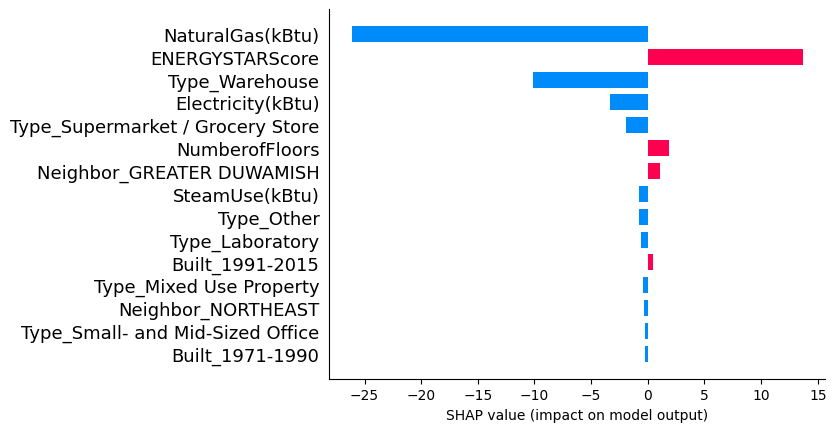

In [38]:
shap.bar_plot(explainer.shap_values(X_test_std[0]),
              feature_names=X_data.columns,
                 max_display=15)

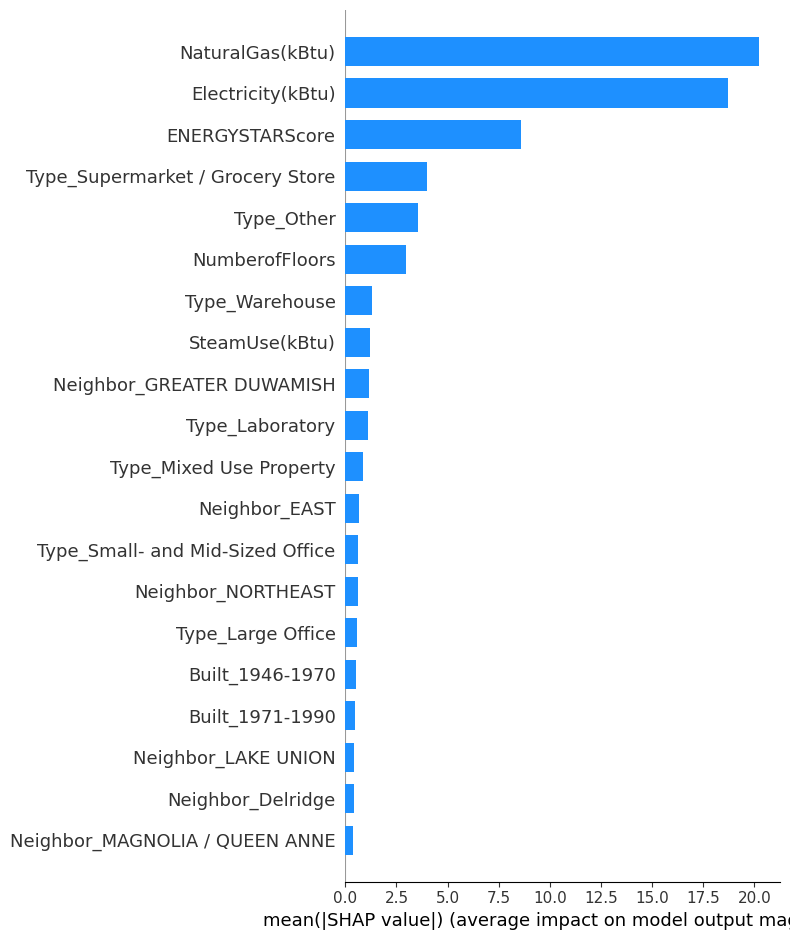

In [39]:
# l'importance relative de chaque variable explicative pour les prédictions du modèle.
shap.summary_plot(explainer.shap_values(X_test_std),
                  feature_names=X_data.columns,
                  plot_type="bar",
                  color="dodgerblue"
                  )

### 3.3.4. Ensembliste parallèle: Bagging Regression avec Arbre de décision

In [40]:
from sklearn.ensemble import BaggingRegressor
from sklearn.tree import DecisionTreeRegressor

# Division des données en ensembles d'apprentissage et de test
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Construction du modèle de bagging avec 10 arbres de décision
model = BaggingRegressor(base_estimator=DecisionTreeRegressor(),
                            n_estimators=10, random_state=42)

# Apprentissage du modèle sur les données d'apprentissage
model.fit(X_train, y_train)

# Prédiction des valeurs de la variable cible pour les données de test
y_pred = model.predict(X_test)
y_pred_train = model.predict(X_train)

mse, rmse, r2 = performance(y_train, y_pred_train)
y_resultat = ['Bagging Tree train', mse,rmse, r2 ]
performance_list.append(y_resultat)

mse, rmse, r2 = performance(y_test, y_pred)
y_resultat = ['Bagging Tree test', mse, rmse, r2]
performance_list.append(y_resultat)

MSE :  487.08  RMSE:  22.07  R2 : 0.92
MSE :  1669.16  RMSE:  40.86  R2 : 0.6


Hyper paramètres pour Bagging

In [41]:
# Définir le modèle de base  (running time = 20s)
base_model = DecisionTreeRegressor()

# Définir le modèle Bagging avec GridSearchCV
bagging_model = GridSearchCV(BaggingRegressor(base_estimator=base_model),
                             param_grid={'n_estimators': [10, 100, 500]},
                             cv=5)

# Adapter le modèle sur les données d'entraînement
bagging_model.fit(X_train, y_train)

# Obtenir les meilleurs hyper-paramètres et le score R2 correspondant
print("Meilleurs hyper-paramètres : ", bagging_model.best_params_)
print("Score R2 : ", bagging_model.best_score_)

# Utiliser les meilleurs paramètres pour ajuster le modèle final
bagging_final = bagging_model.best_estimator_
#bagging_final = RandomForestRegressor(**bagging_model.best_params_)
#bagging_final.fit(X_train, y_train)

# Prédiction des valeurs de la variable cible pour les données de test
y_pred = bagging_final.predict(X_test)

y_pred_train = bagging_final.predict(X_train)

mse, rmse, r2 = performance(y_train, y_pred_train)
y_resultat = ['Bagging Hyperparametre train', mse,rmse, r2 ]
performance_list.append(y_resultat)

mse, rmse, r2 = performance(y_test, y_pred)
y_resultat = ['Bagging Hyperparametre test', mse, rmse, r2]
performance_list.append(y_resultat)

Meilleurs hyper-paramètres :  {'n_estimators': 100}
Score R2 :  0.5931594056738687
MSE :  344.86  RMSE:  18.57  R2 : 0.94
MSE :  1336.92  RMSE:  36.56  R2 : 0.68


### 3.3.5 Ensembliste séquentielle : GBoostRegression

GBoost Model 

In [42]:
from sklearn.ensemble import GradientBoostingRegressor

# Division des données en ensembles d'apprentissage et de test
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Initialiser le modèle Gradient Boosting Regressor
gb_reg = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)

# Entraîner le modèle sur l'ensemble de données d'entraînement
gb_reg.fit(X_train, y_train)

# Prédire les valeurs de sortie sur l'ensemble de données de test
y_pred = gb_reg.predict(X_test)
y_pred_train = gb_reg.predict(X_train)

# Calculer l'erreur du modèle
mse, rmse, r2 = performance(y_train, y_pred_train)
y_resultat = ['GBoost regression train', mse,rmse, r2 ]
performance_list.append(y_resultat)

mse, rmse, r2 = performance(y_test, y_pred)
y_resultat = ['GBoost regression test', mse, rmse, r2]
performance_list.append(y_resultat)

MSE :  846.33  RMSE:  29.09  R2 : 0.86
MSE :  1446.83  RMSE:  38.04  R2 : 0.65


In [43]:
# Définir le modèle GBoostRegression avec GridSearchCV   ( running time = 10 min , CPU at 30%)
gboost_model = GridSearchCV(GradientBoostingRegressor(),
                            param_grid={'n_estimators': [50, 100, 200],
                                        'max_depth': [2, 4, 6],
                                        'learning_rate': [0.01, 0.1, 1],
                                        'subsample': [0.5, 0.8, 1.0],
                                        'loss': ['ls', 'lad', 'huber']},
                            cv=5)

# Adapter le modèle sur les données d'entraînement
gboost_model.fit(X_train, y_train)

# Obtenir les meilleurs hyper-paramètres et le score R2 correspondant
print("Meilleurs hyper-paramètres : ", gboost_model.best_params_)
print("Score R2 : ", gboost_model.best_score_)

# Utiliser les meilleurs paramètres pour ajuster le modèle final
gboost_final = gboost_model.best_estimator_

# Prédiction des valeurs de la variable cible pour les données de test
y_pred = gboost_final.predict(X_test)

# Calculer l'erreur du modèle
mse, rmse, r2 = performance(y_train, y_pred_train)
y_resultat = ['GBoost regression train', mse,rmse, r2 ]
performance_list.append(y_resultat)

mse, rmse, r2 = performance(y_test, y_pred)
y_resultat = ['GBoost regression test', mse, rmse, r2]
performance_list.append(y_resultat)

Meilleurs hyper-paramètres :  {'learning_rate': 0.1, 'loss': 'huber', 'max_depth': 4, 'n_estimators': 200, 'subsample': 1.0}
Score R2 :  0.6204329517758413
MSE :  846.33  RMSE:  29.09  R2 : 0.86
MSE :  1803.95  RMSE:  42.47  R2 : 0.57


In [44]:
shap.initjs()
# Calculer les contributions SHAP pour chaque caractéristique pour une prédiction donnée
explainer = shap.TreeExplainer(gboost_final)
shap_values = explainer.shap_values(X_test[0])

# Afficher les contributions SHAP pour chaque caractéristique

shap.force_plot(explainer.expected_value,
                explainer.shap_values(X_test[0]),
                feature_names=X_data.columns,
                out_names="SiteEUI(kBtu/sf)")

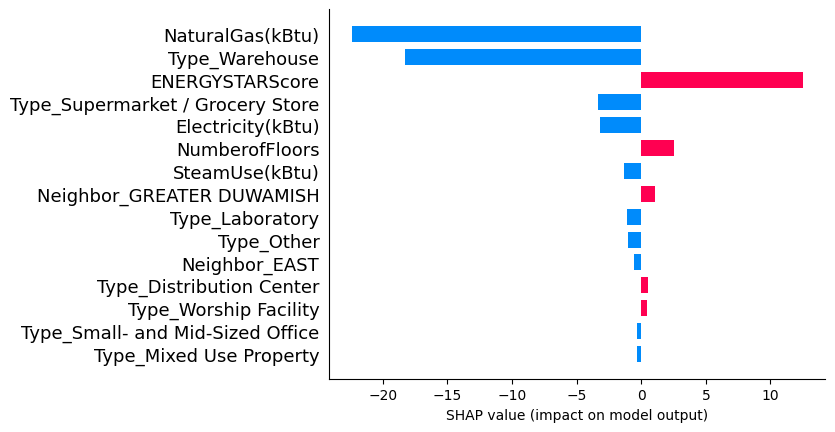

In [45]:
shap.bar_plot(explainer.shap_values(X_test[0]),
              feature_names=X_data.columns,
                 max_display=15)

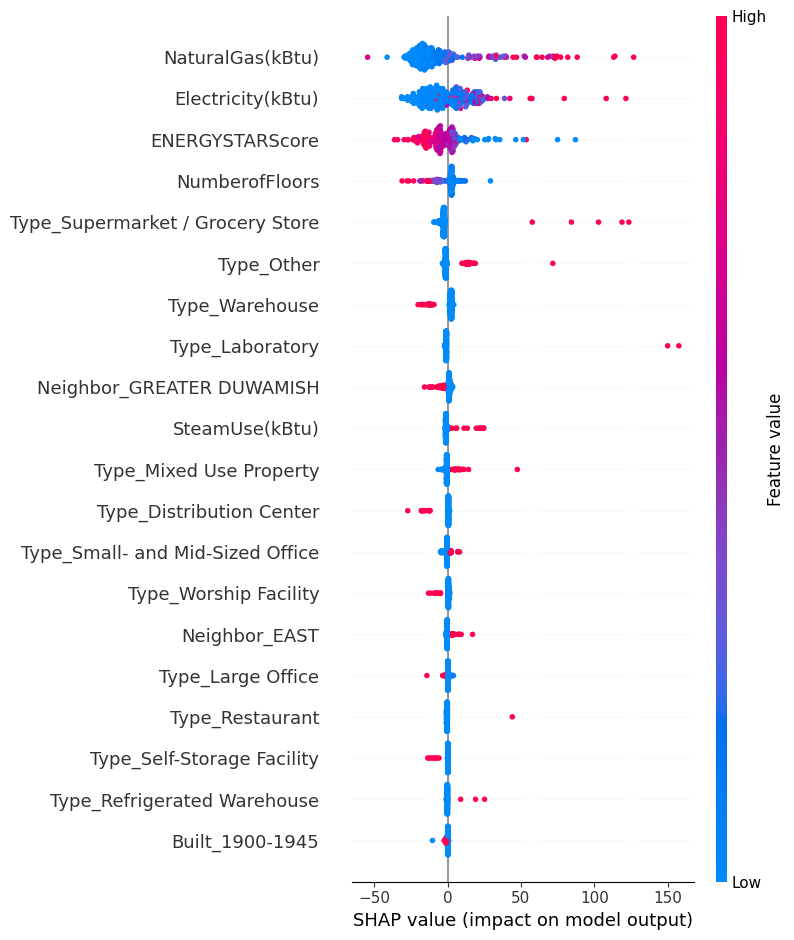

In [46]:
shap.summary_plot(explainer.shap_values(X_test),
                  features = X_test,
                  feature_names=X_data.columns)

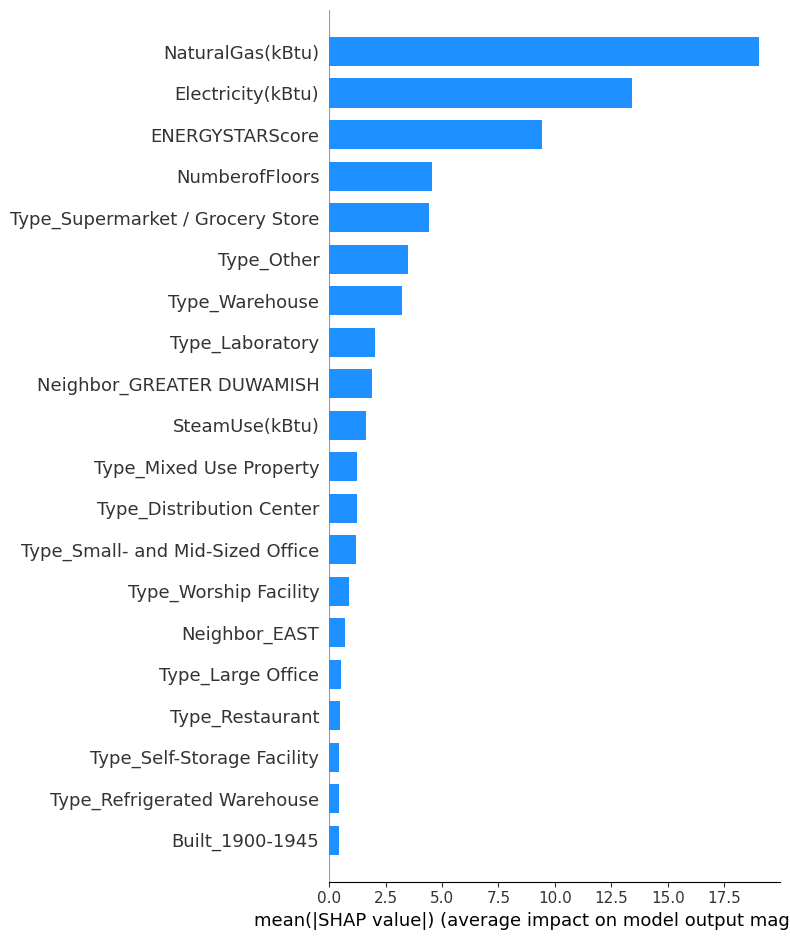

In [47]:
# l'importance relative de chaque variable explicative pour les prédictions du modèle.
shap.summary_plot(explainer.shap_values(X_test),
                  feature_names=X_data.columns,
                  plot_type="bar",
                  color="dodgerblue"
                  )

### 3.3.6 Arbre de décision 

In [48]:
from sklearn.tree import DecisionTreeRegressor

# création d'un objet d'arbre de décision de régression
regressor = DecisionTreeRegressor(random_state=42)

# entraînement de l'arbre de décision sur les données d'entraînement
regressor.fit(X_train, y_train)

# prédiction des résultats de la variable dépendante sur les données de test
y_pred = regressor.predict(X_test)
y_train_pred = regressor.predict(X_train)

# Calculer l'erreur du modèle
mse, rmse, r2 = performance(y_train, y_pred_train)
y_resultat = ['Arbre de decision train', mse,rmse, r2 ]
performance_list.append(y_resultat)

mse, rmse, r2 = performance(y_test, y_pred)
y_resultat = ['Arbre de decision test', mse, rmse, r2]
performance_list.append(y_resultat)

MSE :  846.33  RMSE:  29.09  R2 : 0.86
MSE :  2582.45  RMSE:  50.82  R2 : 0.38


In [49]:
conso_result = pd.DataFrame(performance_list, columns=['Modele', 'MSE', 'RMSE', 'R2'])
conso_result.to_csv('consommation_result.csv')